# ODSC West 2022 Tutorial: 
### Objective: Gain intuition into the parameters that define a sinusoisal model
- Kirstin Aschbacher
- Sept 2022

In [60]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, optimize

pd.set_option("display.width", 500)
np.printoptions("precision", 2)

In [97]:
class SineFit:

    def __init__(self, time: np.ndarray, series: np.ndarray, lsq_options: dict, window_length: int=30, window_step: int=4):
        self.t = time
        self.y = series
        self.y_sinefit = np.asarray([np.nan for i in range(series.size)])
        self.lsq_options = lsq_options
        self.w_length = window_length
        self.w_step = window_step
        self.labels = SineFit.get_labels()
        self.is_fitted = False

    @staticmethod
    def get_labels() -> List[str]:
        """Note: The order of these labels should correspond with the ordering of bounds scalars,
        with the addition of error at the end"""
        return ["omega", "amplitude", "mean HR", "phi", "error"]

    @staticmethod
    def do_sinefit(x: List[float], t: np.ndarray) -> float:
        """Given a set of 4 initial parameters, return predicted y for sine fx
        params: angular frequency, amplitude, y-intercept shift, radians offset

        Args:
            x (array): sine model parameters = [omega, A, yint, phi]
            t (array): window of time, units (min), during HRV biofeedback
        """
        [omega, A, yint, phi] = x
        return A * np.sin((omega * t) + phi) + yint

    @staticmethod
    def get_residuals(x: List[float], t: np.ndarray, y: np.ndarray) -> float:
        """Given a set of 4 parameters, return the residuals to a f(x) sine fit function.
        time, frequency (in time domain), amplitude, y-intercept shift, phase = radians offset.
        """
        # Note: Scipy example uses yhat - y, but this conflicts with other definitions of residual as observed - predicted
        # Arguably, if squared, doesn't matter
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
        # https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/residual/
        assert len(x) == 4
        ypred = SineFit.do_sinefit(x, t)
        return ypred - y

    @staticmethod
    def initialize_params() -> np.ndarray:
        """Get a set of initializing parameters for the sinusoidal model"""
        # I've set some defaults here which work well for this signal, but may not for all signals
        meanHR = 74.0
        amplitude = 3.0
        phi = 0
        omega = 0.1 * 2 * np.pi  # Angular freqency for the breathing pace of 6bpm, or .1 Hz
        return np.array([omega, amplitude, meanHR, phi])

    @staticmethod
    def _print_param_info(i: int, vals: List[float], prms: List[float]):
        """Helper function to understand how params are initialized vs final fit values"""
        print(f"i={i}, initialize A={vals[1]:.4f}, meanHR={vals[2]:.4f}, fitted A={prms[1]:.4f}, meanHR={prms[2]:.4f}")
        
    def rolling_sinefit(self, method: str="propagate") -> None:
        """Loop over windows, fitting a sinusoidal model to the data in each window and storing results"""
        assert method in ["reinitialize", "propagate"]
        t = self.t
        y = self.y
        w_length = self.w_length
        w_step = self.w_step
        lsq_options = self.lsq_options.copy()  # Leave the original intact
        initial_values = SineFit.initialize_params()
        fits = {}
        # print(f"The initial values: {initial_values}")

        # Rolling windows over the signal
        for i in range(w_length, len(y), w_step):
            t_i = np.copy(t[i-w_length: i])
            y_i = np.copy(y[i-w_length: i])

            if method == "reinitialize":
                initial_values = SineFit.initialize_params()

            res_lsq = optimize.least_squares(
                SineFit.get_residuals,
                initial_values,
                args=(t_i, y_i),
                **lsq_options
            )
            fit_params = res_lsq.x
            
            # Record the predicted y from sinefit, and align with window that was modeled, keeping first w_step
            y_pred = SineFit.do_sinefit(fit_params, t_i).round(4)
            start = i-w_length
            self.y_sinefit[start: start+w_step] = y_pred[:w_step]
            error = res_lsq.cost

            # Debugging & Understanding
            if i < (5 * w_step) + w_length:
                SineFit._print_param_info(i, initial_values, fit_params)

            if method == "propagate":
                initial_values = fit_params
            
            # Record fitted parameters + error for each window
            all_params = np.concatenate((fit_params, [error]))
            fits[i] = dict(zip(self.labels, all_params))
        
        self.is_fitted = True
        return fits

    def do_predict(self) -> np.ndarray:
        if self.is_fitted:
            return self.y_sinefit
        else:
            raise ValueError("Model must be fitted first. Run SineFit.rolling_sinefit()")

    def return_parameter_df(self, fits: dict) -> pd.DataFrame:
        return pd.DataFrame.from_dict(fits, orient="index")

    @staticmethod
    def plot_solution(
        t: np.ndarray, y: np.ndarray, y_sinefit: np.ndarray, amplitudes: np.ndarray, w_length: int, w_step: int, ylims: tuple = None
    ) -> None:
        """Plot the original HR data, the y_sinefit solution, and the amplitude parameters.
        """
        fig, axs = plt.subplots(3, 1, figsize=(18, 6), sharex=True)
        axs[0].plot(t, y, color='navy')
        axs[0].set_title("Instant Heart Rate", fontsize=12)
        lower, upper = axs[0].get_ylim()
        
        axs[1].plot(t, y_sinefit, color='teal')
        axs[1].set_title("Predicted Heart Rate per the Sinusoidal Model", fontsize=12)
        axs[1].set_ylim(lower, upper)

        # Build a new time vector w same size as amplitude parameter
        # We will align the amplitude in the center of the window it was fitted on
        n_window_fits = int((t.size - w_length) / w_step)
        half_window = int(w_length/2)
        t_amps = np.asarray([t[half_window + (i*w_step)] for i in range(n_window_fits)])
        min_size = min(t_amps.size, amplitudes.size)
        axs[2].plot(t_amps[:min_size], amplitudes[:min_size], color="m")
        axs[2].set_title("Rolling Amplitude Parameter", fontsize=12)
        if ylims is not None:
            axs[2].set_ylim(ylims)

        plt.subplots_adjust(hspace = .3)
        plt.show()
        
    @staticmethod
    def metrics_summary(amps: np.ndarray, error: np.ndarray):
        """Here are some metrics we might want to use to compare different models.
        We care about comparing how well two different models fit the data, using the error. 
        We also care about the user experience.  If the amplitude suddenly drops and rises again,
        this would cause the pacer color to change rapidly, potentially confusing the user.
        This behavior would be reflected in the second order difference of the amplitude series.
        """
        print(f"--- Results Metrics ---")
        print(f"Mean Absolute Error: {np.abs(error).mean():.2f}")
        print(f"Max Error: {error.max():.2f}")
        print(f"Std Amplitude: {amps.std():.2f}")
        print(f"Max 2-order Diff Amplitude: {np.diff(amps, 2).max():.2f}")

### Load Data

In [98]:
hrv_fpath = "data/odsc_testdata_edited.csv"
df = pd.read_csv(hrv_fpath, encoding="utf-8", index_col="rawrrID")
df.head(3)

,rawRR
rawrrID,
0,843
1,882
2,914


In [99]:
def preprocess(user_df: pd.DataFrame, col: str="rawRR") -> pd.DataFrame:
    """Build a time vector from the RR or NN intervals.
    Build an instant HR column from the RR or NN intervals.
    """

    # Compute time in seconds, so that the first beat starts at 0 seconds
    firstHR = user_df[col].iloc[0] / 1000
    user_df["time"] = user_df[col].cumsum() / 1000 - firstHR

    # Compute instant HR from raw RR
    user_df["heartRate"] = np.divide(60000, user_df[col])
    return user_df

df = preprocess(df)
df.head(3)

,rawRR,time,heartRate
rawrrID,,,
0,843,0.000,71.174377
1,882,0.882,68.027211
2,914,1.796,65.645514


In [100]:
# Initialize the model options and the bounds scalars
lsq_options = {
    "method": "trf",
    "max_nfev": 10000,
    "gtol": .1,
    "bounds": [
        [.08 * 2 * np.pi, 0, 40, 0], 
        [.12 * 2 * np.pi, 40, 110, 2 * np.pi]
    ]
}
window_length=30
window_step=4

# Instantiate the SineFit class
t = df["time"].values
y = df["heartRate"].values
SF = SineFit(t, y, lsq_options, window_length, window_step)

# Fit the Model
fits = SF.rolling_sinefit(method="reinitialize")

# Get the model predicted values
y_sinefit = SF.do_predict()

i=30, initialize A=3.0000, meanHR=74.0000, fitted A=6.6303, meanHR=66.7518
i=34, initialize A=3.0000, meanHR=74.0000, fitted A=8.6889, meanHR=65.6160
i=38, initialize A=3.0000, meanHR=74.0000, fitted A=9.4002, meanHR=65.4037
i=42, initialize A=3.0000, meanHR=74.0000, fitted A=9.5524, meanHR=63.7400
i=46, initialize A=3.0000, meanHR=74.0000, fitted A=10.0253, meanHR=63.4514


In [101]:
# Get a DataFrame of the sinefit parameters and error for each rolling window
sinefit_df = SF.return_parameter_df(fits)
sinefit_df.head(2)

,omega,amplitude,mean HR,phi,error
30,0.556303,6.630304,66.751840,2.395299e-21,346.507697
34,0.576121,8.688891,65.615969,1.033917e-15,473.676846


### Plot the Results & Print Key Metrics
* Here we reinitialize with each window

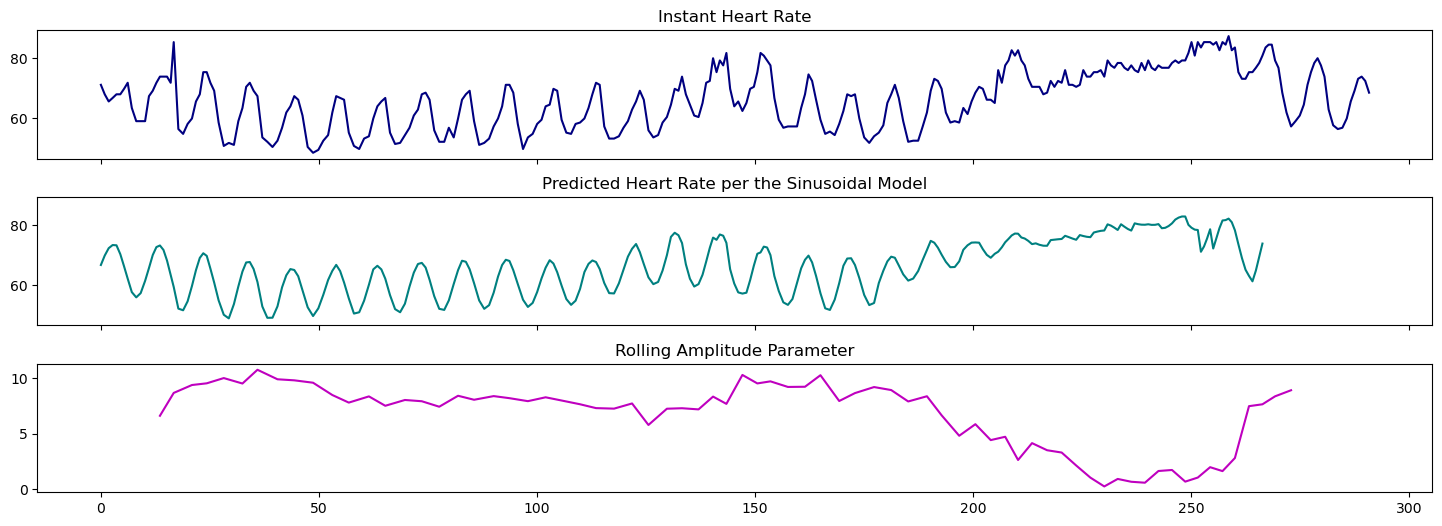

--- Results Metrics ---
Mean Absolute Error: 255.45
Max Error: 816.20
Std Amplitude: 3.00
Max 2-order Diff Amplitude: 3.61


In [102]:
amps = sinefit_df["amplitude"].values
error = sinefit_df["error"].values

SF.plot_solution(t, y, y_sinefit, amps, window_length, window_step)
SF.metrics_summary(amps, error)

### Contrast with the propagate method
* Here we see that the model quickly finds the optimal parameter space
* The mean absolute error goes down slightly, but otherwise both approaches work for this waveform and this sklearn TRF algo
* We have found that, at scale, there will be many waveforms that behave differently.
* Also, other LM algorithms may not behave as robustly, given a less ideal waveform
* Hence, it is valuable to experiment with different ways to tune the model at scale

i=30, initialize A=3.0000, meanHR=74.0000, fitted A=6.6303, meanHR=66.7518
i=34, initialize A=6.6303, meanHR=66.7518, fitted A=8.6889, meanHR=65.6160
i=38, initialize A=8.6889, meanHR=65.6160, fitted A=9.4002, meanHR=65.4037
i=42, initialize A=9.4002, meanHR=65.4037, fitted A=9.5525, meanHR=63.7400
i=46, initialize A=9.5525, meanHR=63.7400, fitted A=10.0253, meanHR=63.4514


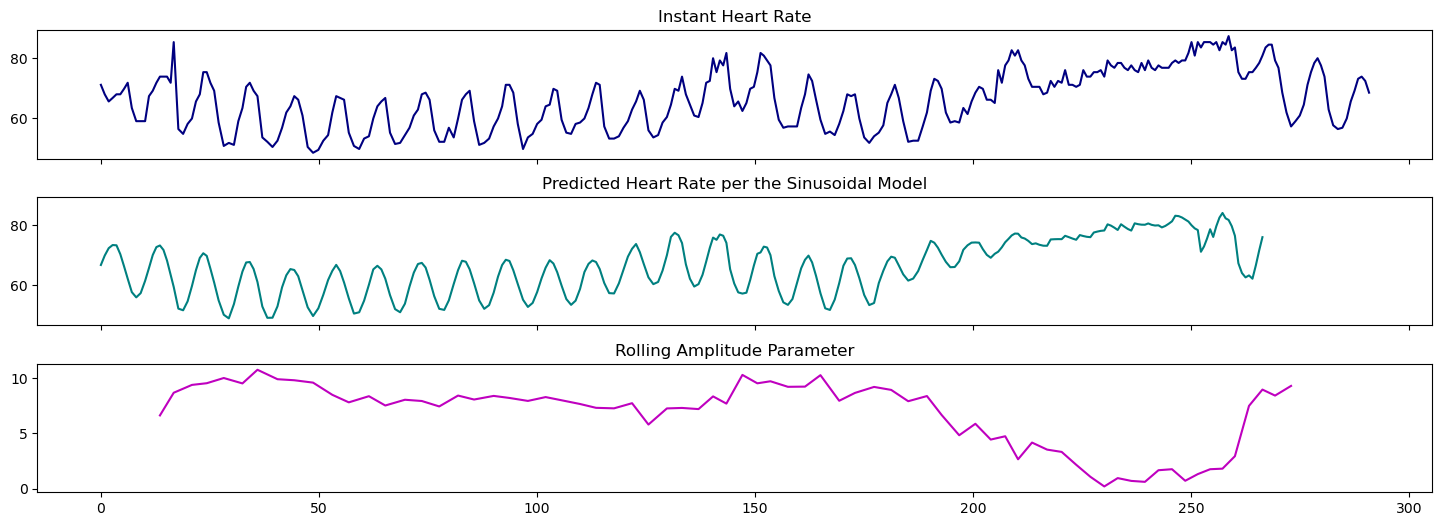

--- Results Metrics ---
Mean Absolute Error: 250.21
Max Error: 816.20
Std Amplitude: 3.02
Max 2-order Diff Amplitude: 3.61


In [104]:
# Fit the Model
fits = SF.rolling_sinefit(method="propagate")

# Get the model predicted values
y_sinefit = SF.do_predict()

# Build a dataframe of model fit params
sinefit_df = SF.return_parameter_df(fits)

# Compute & Plot
amps = sinefit_df["amplitude"].values
error = sinefit_df["error"].values

SF.plot_solution(t, y, y_sinefit, amps, window_length, window_step)
SF.metrics_summary(amps, error)

### Which window generated the maximum error?
* We might want to look deeper to find when in the signal the maximal error occured.

In [115]:
# Find the index where error was at its maximum
max_error_idx = np.where(sinefit_df["error"] == sinefit_df["error"].max())[0]
sinefit_df.iloc[max_error_idx[0]]

omega        6.338277e-01
amplitude    5.872771e+00
mean HR      6.787452e+01
phi          5.420417e-12
error        8.162002e+02
Name: 222, dtype: float64

In [116]:
# Now map that back into the original time vector
start = max_error_idx[0]*window_step
df.iloc[start: start+window_length].head()

,rawRR,time,heartRate
rawrrID,,,
192,1140,186.319,52.631579
193,1140,187.459,52.631579
194,1046,188.505,57.361377
195,968,189.473,61.983471
196,867,190.340,69.204152


### Summary:
* If we look back at the graph, we see that the window with the maximal error starts around t=186.
* This is when the test user stopped doing HRV-B and started breathing very quickly, losing the sinusoidal waveform.
* So, we learn that, at least some of the time, high errors might point to user errors or lapses in correct breathing.
* How might we use this in our product offering?